In [1]:
# data manipulation
import numpy as np
import pandas as pd

from datetime import datetime
import itertools

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR

from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

import math

# data visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import csv

from pylab import rcParams

import warnings
warnings.filterwarnings('ignore')

import acquire
import prepare

# default pandas decimal number display format
pd.options.display.float_format = '{:20,.2f}'.format
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Acquire Fitbit data

In [2]:
df = acquire.merge_dataframes()

In [3]:
df.shape

(225, 10)

In [4]:
df.head()

,date,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories
1,2018-04-26,"2,635","2,931",1.38,2,"1,347",93,0,0,566
2,2018-04-27,"3,649","9,971",4.7,19,"1,158",219,46,17,"1,752"
3,2018-04-28,"3,379","3,521",1.66,2,702,155,22,11,"1,124"
4,2018-04-29,"2,851","1,639",0.77,0,891,122,0,0,602
5,2018-04-30,"2,825","1,323",0.62,0,880,104,0,0,540


In [5]:
def missing_values_col(df):
    """
    Write or use a previously written function to return the
    total missing values and the percent missing values by column.
    """
    null_count = df.isnull().sum()
    null_percentage = (null_count / df.shape[0]) * 100
    empty_count = pd.Series(((df == ' ') | (df == '')).sum())
    empty_percentage = (empty_count / df.shape[0]) * 100
    nan_count = pd.Series(((df == 'nan') | (df == 'NaN')).sum())
    nan_percentage = (nan_count / df.shape[0]) * 100
    return pd.DataFrame({'num_missing': null_count, 'missing_percentage': null_percentage,
                         'num_empty': empty_count, 'empty_percentage': empty_percentage,
                         'nan_count': nan_count, 'nan_percentage': nan_percentage})

missing_values_col(df)

,num_missing,missing_percentage,num_empty,empty_percentage,nan_count,nan_percentage
date,0,0.00,0,0.00,0,0.00
calories_burned,0,0.00,0,0.00,0,0.00
steps,0,0.00,0,0.00,0,0.00
distance,0,0.00,0,0.00,0,0.00
floors,0,0.00,0,0.00,0,0.00
minutes_sedentary,0,0.00,0,0.00,0,0.00
minutes_lightly_active,0,0.00,0,0.00,0,0.00
minutes_fairly_active,0,0.00,0,0.00,0,0.00
minutes_very_active,0,0.00,0,0.00,0,0.00
activity_calories,0,0.00,0,0.00,0,0.00


# Prepare

In [6]:
df = prepare.update_dtypes(df)

In [7]:
df.dtypes

calories_burned             int64
steps                       int64
distance                  float64
 floors                     int64
minutes_sedentary           int64
minutes_lightly_active      int64
minutes_fairly_active       int64
minutes_very_active         int64
activity_calories           int64
dtype: object

# Exploration

In [8]:
df[df.steps <= 500].shape

(17, 9)

In [9]:
df[df.minutes_sedentary >= 1440]

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories
date,,,,,,,,,
2018-06-06,2145,0,0.00,0,1440,0,0,0,0
2018-06-07,2146,0,0.00,0,1440,0,0,0,0
2018-06-11,2146,0,0.00,0,1440,0,0,0,0
2018-06-26,2144,0,0.00,0,1440,0,0,0,0
2018-06-27,2145,0,0.00,0,1440,0,0,0,0
2018-06-28,2145,0,0.00,0,1440,0,0,0,0
2018-06-30,2145,0,0.00,0,1440,0,0,0,0
2018-07-03,2144,0,0.00,0,1440,0,0,0,0
2018-07-06,2144,0,0.00,0,1440,0,0,0,0


In [10]:
df.sort_values('steps',ascending=True)

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories
date,,,,,,,,,
2018-06-27,2145,0,0.00,0,1440,0,0,0,0
2018-07-04,2183,0,0.00,0,1438,2,0,0,42
2018-07-03,2144,0,0.00,0,1440,0,0,0,0
2018-06-30,2145,0,0.00,0,1440,0,0,0,0
2018-06-06,2145,0,0.00,0,1440,0,0,0,0
2018-06-07,2146,0,0.00,0,1440,0,0,0,0
2018-06-29,2180,0,0.00,0,1437,3,0,0,39
2018-06-11,2146,0,0.00,0,1440,0,0,0,0
2018-06-28,2145,0,0.00,0,1440,0,0,0,0


In [11]:
df.describe()

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories
count,225.00,225.00,225.00,225.00,225.00,225.00,225.00,225.00,225.00
mean,"3,401.91","8,536.19",4.05,12.59,809.52,188.24,14.92,33.87,"1,484.55"
std,632.43,"5,255.75",2.51,25.84,243.23,75.17,15.36,37.20,747.80
min,799.00,0.00,0.00,0.00,28.00,0.00,0.00,0.00,0.00
25%,"3,069.00","4,714.00",2.22,2.00,654.00,158.00,3.00,2.00,"1,062.00"
50%,"3,385.00","7,806.00",3.68,7.00,750.00,203.00,11.00,15.00,"1,481.00"
75%,"3,765.00","12,380.00",5.90,13.00,877.00,236.00,21.00,63.00,"1,962.00"
max,"5,199.00","25,512.00",12.00,195.00,"1,440.00",349.00,78.00,154.00,"3,596.00"


In [12]:
df.shape

(225, 9)

In [13]:
df['activity'] = df.minutes_lightly_active + df.minutes_fairly_active + df.minutes_very_active

In [14]:
df.head()

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,activity
date,,,,,,,,,,
2018-04-26,2635,2931,1.38,2,1347,93,0,0,566,93
2018-04-27,3649,9971,4.70,19,1158,219,46,17,1752,282
2018-04-28,3379,3521,1.66,2,702,155,22,11,1124,188
2018-04-29,2851,1639,0.77,0,891,122,0,0,602,122
2018-04-30,2825,1323,0.62,0,880,104,0,0,540,104


In [15]:
activity_daily_ratio = df.activity / 1440
activity_daily_ratio

date
2018-04-26                   0.06
2018-04-27                   0.20
2018-04-28                   0.13
2018-04-29                   0.08
2018-04-30                   0.07
2018-05-01                   0.13
2018-05-02                   0.06
2018-05-03                   0.12
2018-05-04                   0.04
2018-05-05                   0.05
2018-05-06                   0.07
2018-05-07                   0.04
2018-05-08                   0.05
2018-05-09                   0.00
2018-05-10                   0.10
2018-05-11                   0.09
2018-05-12                   0.14
2018-05-13                   0.06
2018-05-14                   0.10
2018-05-15                   0.13
2018-05-16                   0.17
2018-05-17                   0.11
2018-05-18                   0.23
2018-05-19                   0.22
2018-05-20                   0.13
2018-05-21                   0.13
2018-05-22                   0.17
2018-05-23                   0.21
2018-05-24                   0.10
2018-05-2

In [16]:
activity_vs_sed_ratio = df.activity / df.minutes_sedentary
activity_vs_sed_ratio

date
2018-04-26                   0.07
2018-04-27                   0.24
2018-04-28                   0.27
2018-04-29                   0.14
2018-04-30                   0.12
2018-05-01                   0.20
2018-05-02                   0.10
2018-05-03                   0.20
2018-05-04                   0.06
2018-05-05                   0.07
2018-05-06                   0.11
2018-05-07                   0.07
2018-05-08                   0.06
2018-05-09                   0.00
2018-05-10                   0.11
2018-05-11                   0.14
2018-05-12                   0.26
2018-05-13                   0.09
2018-05-14                   0.14
2018-05-15                   0.25
2018-05-16                   0.30
2018-05-17                   0.18
2018-05-18                   0.49
2018-05-19                   0.49
2018-05-20                   0.23
2018-05-21                   0.25
2018-05-22                   0.39
2018-05-23                   0.32
2018-05-24                   0.18
2018-05-2

In [17]:
act_vs_all_cals = df.activity_calories / df.calories_burned
act_vs_all_cals

date
2018-04-26                   0.21
2018-04-27                   0.48
2018-04-28                   0.33
2018-04-29                   0.21
2018-04-30                   0.19
2018-05-01                   0.32
2018-05-02                   0.16
2018-05-03                   0.32
2018-05-04                   0.11
2018-05-05                   0.13
2018-05-06                   0.18
2018-05-07                   0.11
2018-05-08                   0.16
2018-05-09                   0.00
2018-05-10                   0.30
2018-05-11                   0.25
2018-05-12                   0.34
2018-05-13                   0.15
2018-05-14                   0.27
2018-05-15                   0.32
2018-05-16                   0.40
2018-05-17                   0.29
2018-05-18                   0.58
2018-05-19                   0.54
2018-05-20                   0.32
2018-05-21                   0.31
2018-05-22                   0.41
2018-05-23                   0.47
2018-05-24                   0.26
2018-05-2

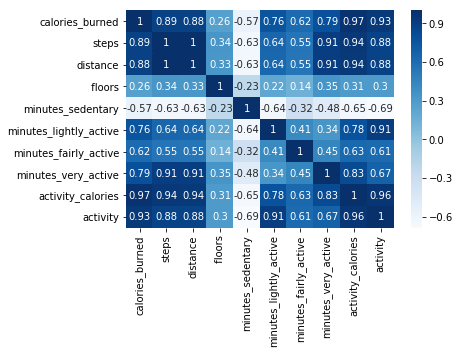

In [18]:
sns.heatmap(df.corr(), cmap='Blues', annot=True)

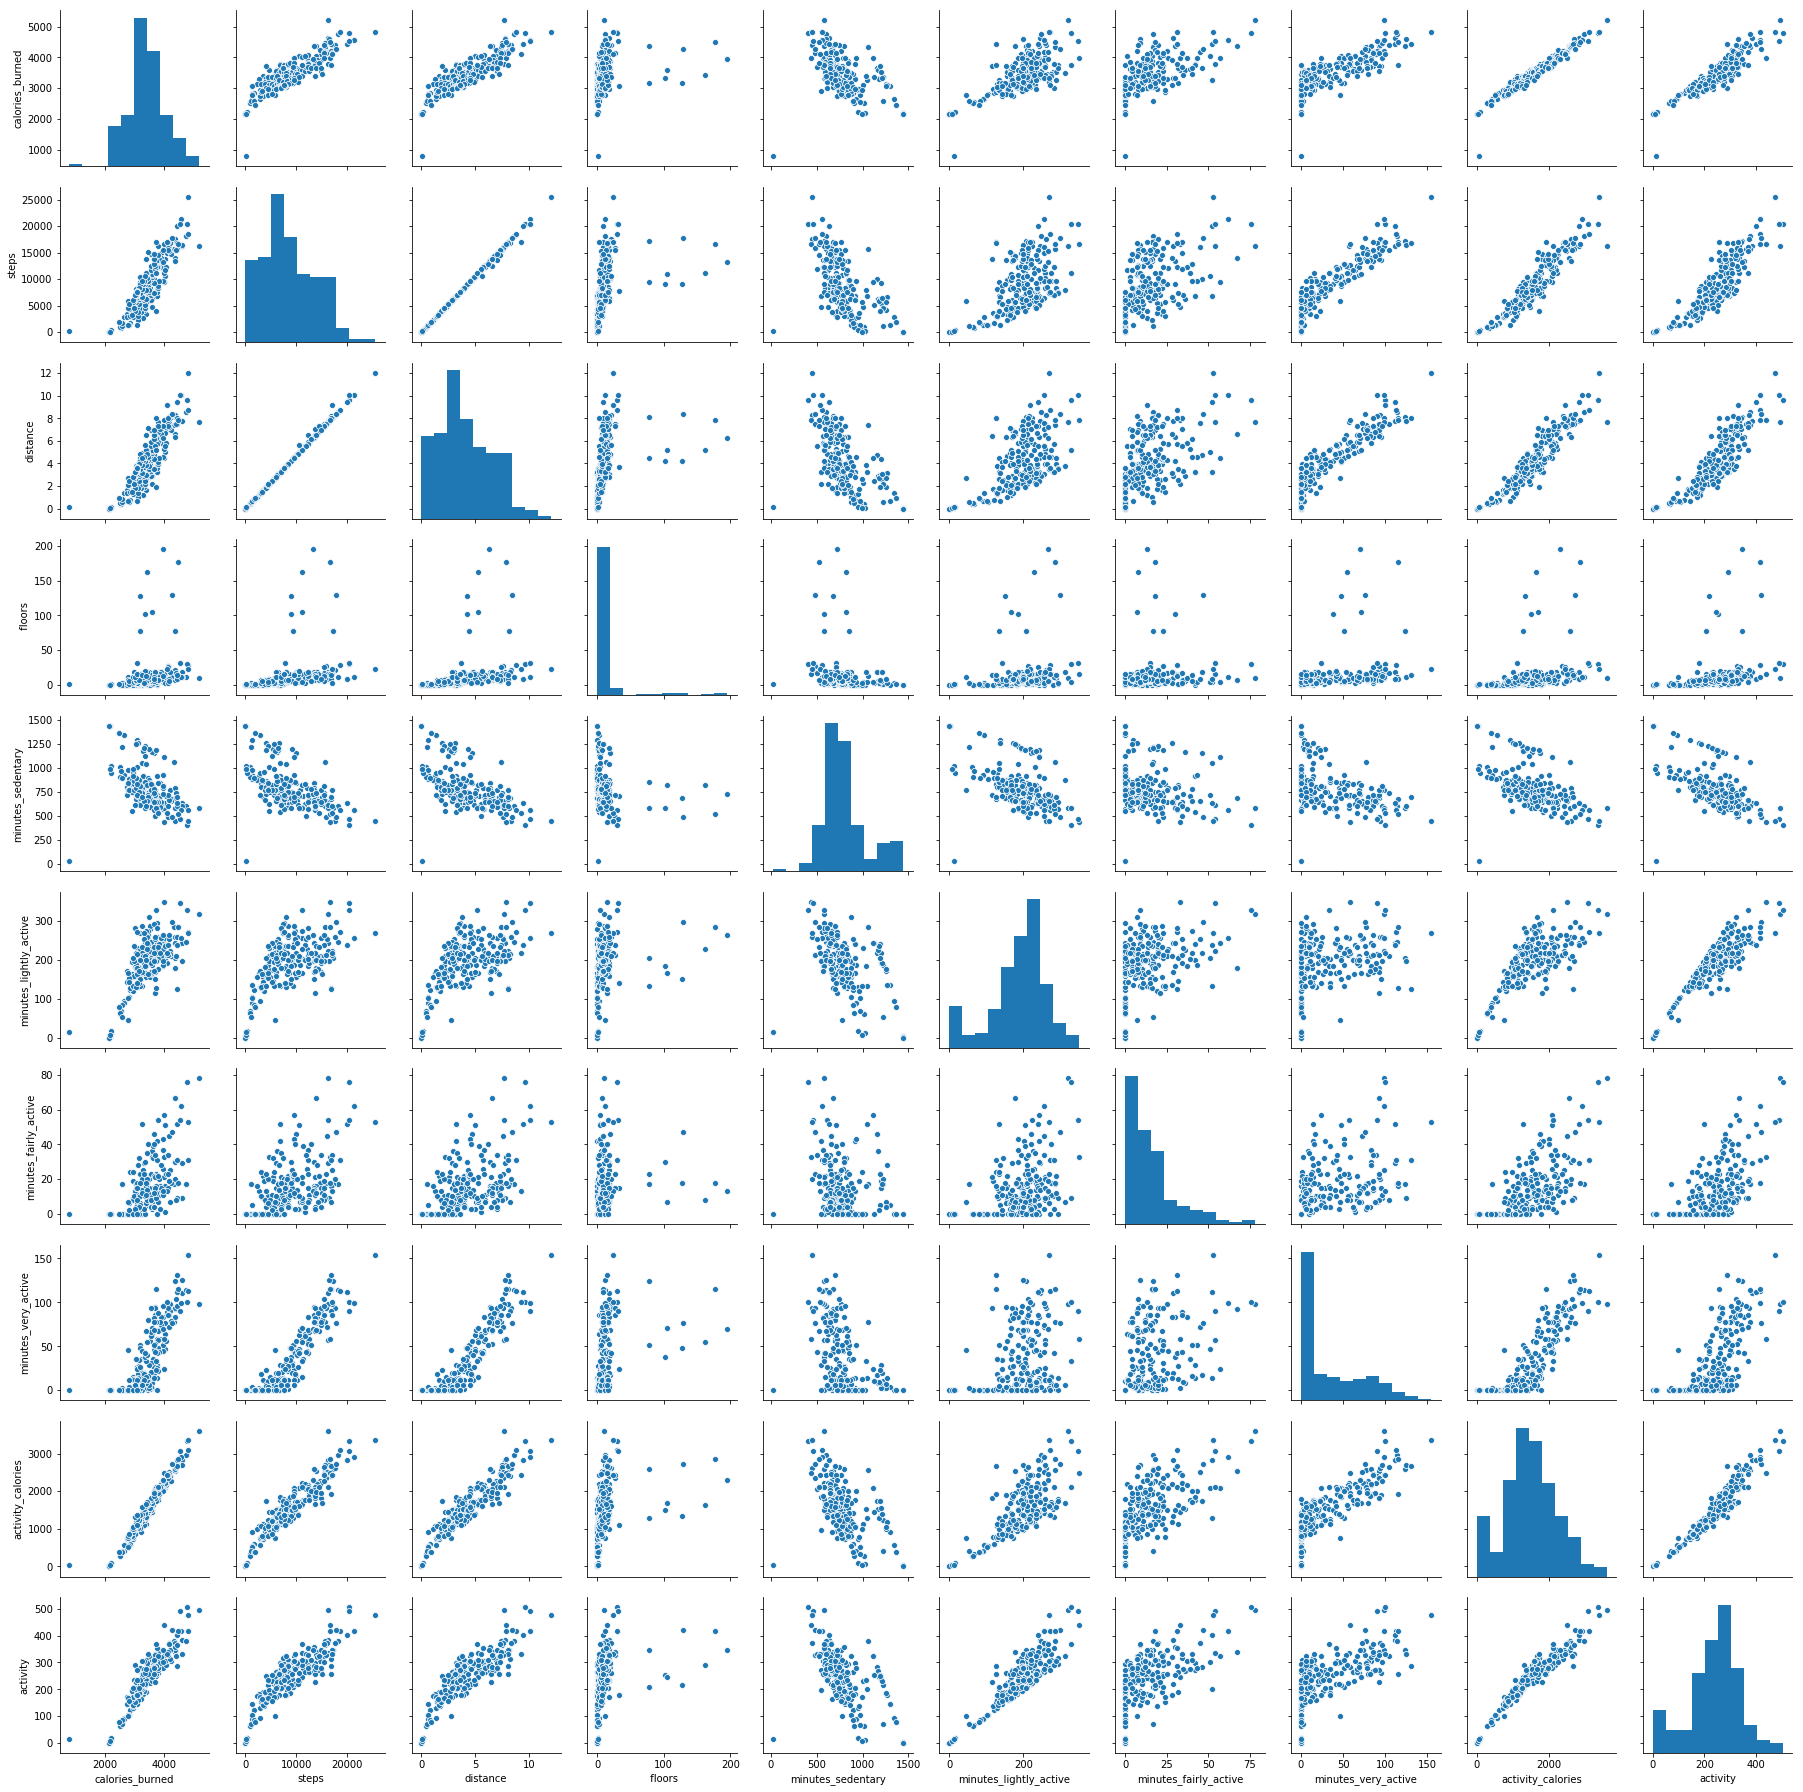

In [19]:
sns.pairplot(df)

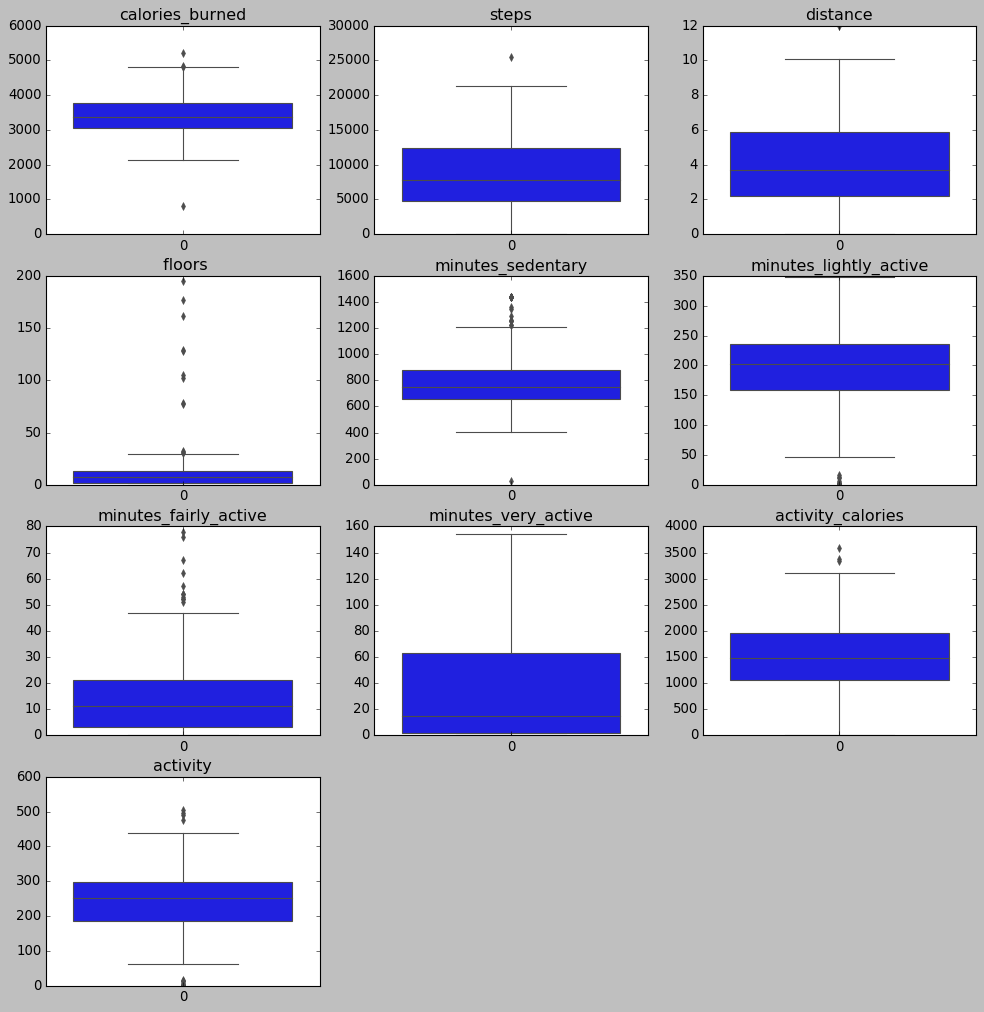

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('classic')


plt.figure(figsize=(15, 15))

for i, col in enumerate(['calories_burned', 'steps', 'distance', ' floors', 'minutes_sedentary','minutes_lightly_active', 'minutes_fairly_active', 'minutes_very_active','activity_calories','activity']):
    plot_number = i + 1 # i starts at 0, but plot nos should start at 1
    series = df[col]
    plt.subplot(4, 3, plot_number)
    plt.title(col)
    sns.boxplot(data=series)

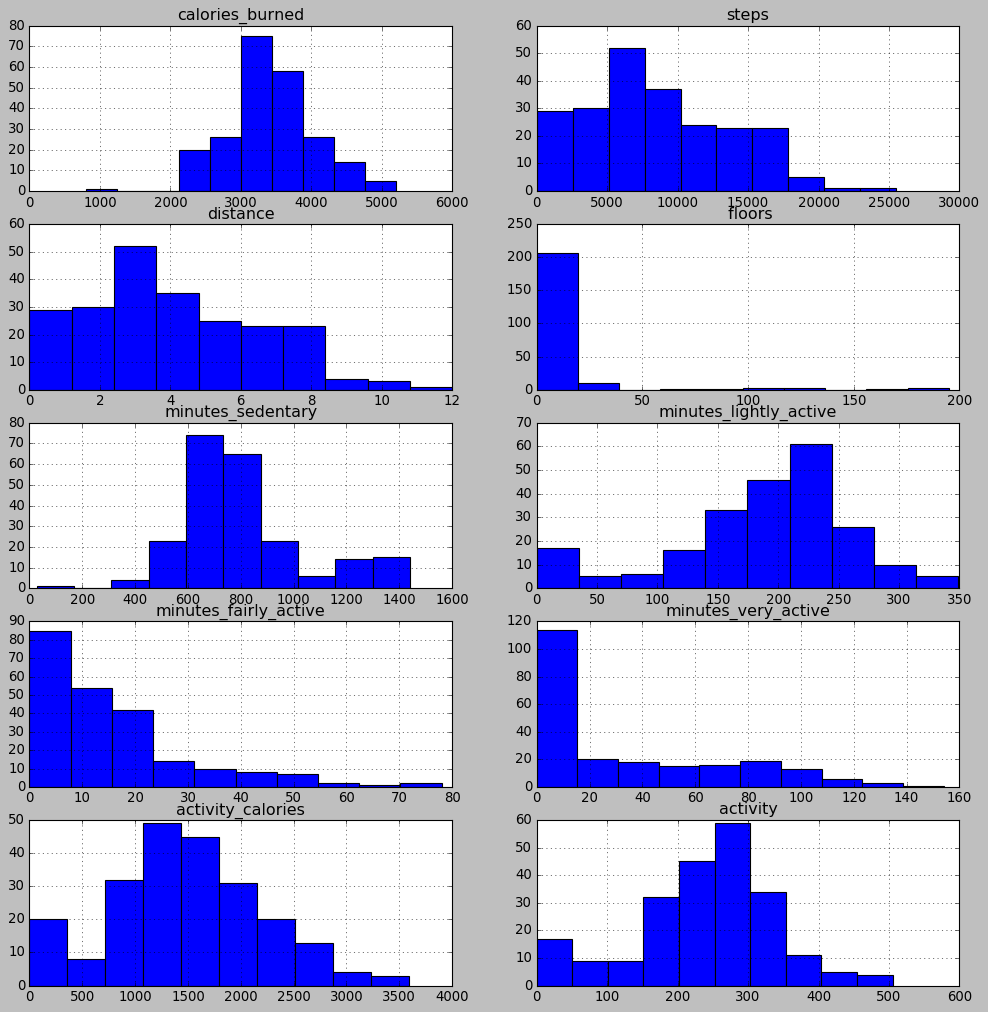

In [21]:
plt.figure(figsize=(15, 15))
for i, col in enumerate(['calories_burned', 'steps', 'distance', ' floors', 'minutes_sedentary','minutes_lightly_active', 'minutes_fairly_active', 'minutes_very_active','activity_calories','activity']):
    plot_number = i + 1  # i starts at 0, but plot nos should start at 1
    series = df[col]
    plt.subplot(5, 2, plot_number)
    plt.title(col)
    series.hist(density=False, cumulative=False, log=False)

In [22]:
df.isna().sum()

calories_burned           0
steps                     0
distance                  0
 floors                   0
minutes_sedentary         0
minutes_lightly_active    0
minutes_fairly_active     0
minutes_very_active       0
activity_calories         0
activity                  0
dtype: int64

In [23]:
train = df[:'2018-10-31']
test = df['2018-11-01':]
print('\nTRAIN:')
print(train.nunique())
print('\nTEST:')
print(test.nunique())


TRAIN:
calories_burned           172
steps                     177
distance                  158
 floors                    30
minutes_sedentary         153
minutes_lightly_active    119
minutes_fairly_active      49
minutes_very_active        75
activity_calories         172
activity                  141
dtype: int64

TEST:
calories_burned           36
steps                     36
distance                  35
 floors                   24
minutes_sedentary         34
minutes_lightly_active    30
minutes_fairly_active     23
minutes_very_active       29
activity_calories         36
activity                  35
dtype: int64


In [24]:
print('\ntrain shape:')
train.shape


train shape:


(189, 10)

In [25]:
print('\ntest shape:')
test.shape


test shape:


(36, 10)

In [26]:
cals = train.resample('D').calories_burned.mean()

In [27]:
cals.head()

date
2018-04-26    2635
2018-04-27    3649
2018-04-28    3379
2018-04-29    2851
2018-04-30    2825
Freq: D, Name: calories_burned, dtype: int64

Text(0.5, 1.0, 'DAYS')

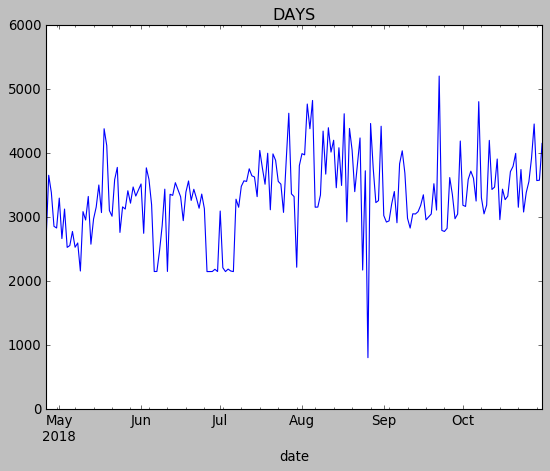

In [111]:
cals.plot()
plt.title('DAYS')

Text(0.5, 1.0, 'WEEKS')

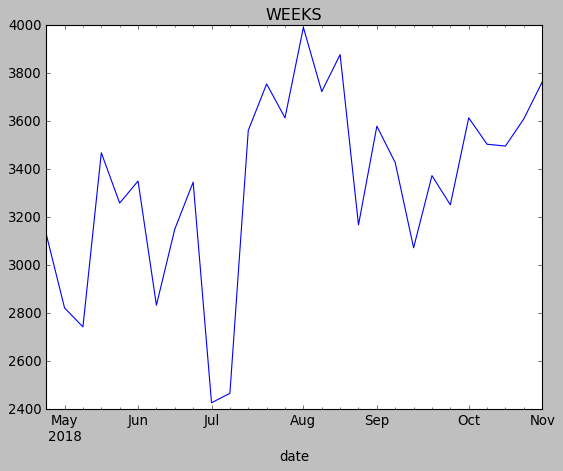

In [110]:
cals.resample('W').mean().plot()
plt.title('WEEKS')

Text(0.5, 1.0, 'MONTHS')

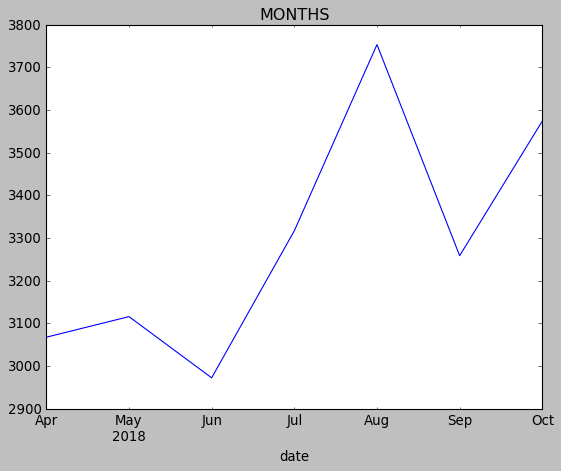

In [113]:
cals.resample('MS').mean().plot()
plt.title('MONTHS')

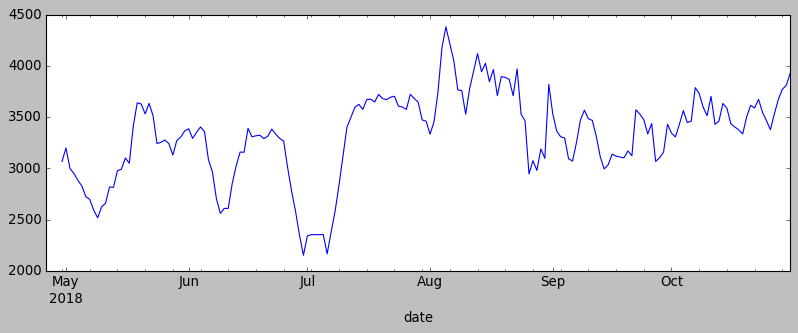

In [31]:
cals.rolling(5).mean().plot(figsize=(12,4))

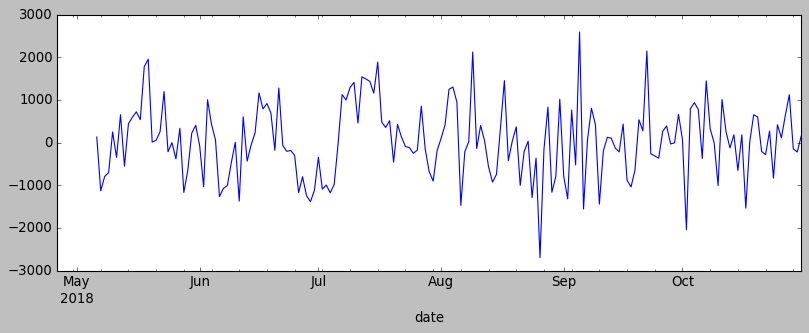

In [32]:
cals.diff(periods=10).plot(figsize=(12,4))

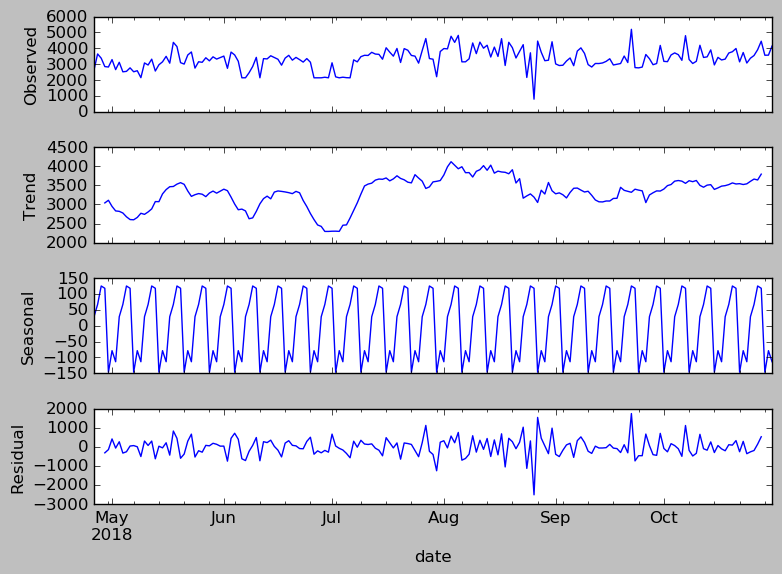

In [33]:
decomposition = sm.tsa.seasonal_decompose(cals, model='additive')
fig = decomposition.plot()
#figsize=(10,10)
fig.set_dpi(100)
plt.show()

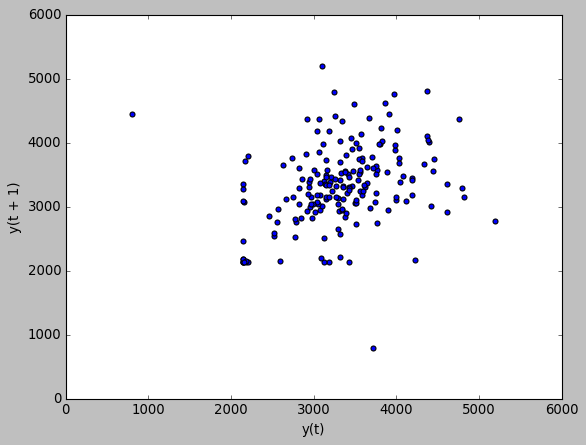

In [34]:
pd.plotting.lag_plot(cals)

In [35]:
df_corr = pd.concat([cals.shift(1),cals], axis=1)
df_corr.columns = ['t-1','t+1']
result = df_corr.corr()
print(result)

                     t-1                  t+1
t-1                 1.00                 0.31
t+1                 0.31                 1.00


### Methods

### Prep the Sampling

In [66]:
aggregation = 'mean'

In [87]:
train = df[:'2018'].calories_burned.resample('D').agg(aggregation)
test = df['2018':].calories_burned.resample('D').agg(aggregation)

### Simple Average

In [88]:
yhat = pd.DataFrame(dict(actual=test))

In [89]:
yhat['avg_forecast'] = train.mean()

In [116]:
yhat.head(10)

,actual,avg_forecast,moving_avg_forecast_15,moving_avg_forecast_30
date,,,,
2018-04-26,2635,"3,401.91","3,614.33","3,756.93"
2018-04-27,3649,"3,401.91","3,614.33","3,756.93"
2018-04-28,3379,"3,401.91","3,614.33","3,756.93"
2018-04-29,2851,"3,401.91","3,614.33","3,756.93"
2018-04-30,2825,"3,401.91","3,614.33","3,756.93"
2018-05-01,3292,"3,401.91","3,614.33","3,756.93"
2018-05-02,2660,"3,401.91","3,614.33","3,756.93"
2018-05-03,3121,"3,401.91","3,614.33","3,756.93"
2018-05-04,2522,"3,401.91","3,614.33","3,756.93"


In [117]:
yhat.tail(6)

,actual,avg_forecast,moving_avg_forecast_15,moving_avg_forecast_30
date,,,,
2018-12-01,3813,"3,401.91","3,614.33","3,756.93"
2018-12-02,3957,"3,401.91","3,614.33","3,756.93"
2018-12-03,3660,"3,401.91","3,614.33","3,756.93"
2018-12-04,3384,"3,401.91","3,614.33","3,756.93"
2018-12-05,3670,"3,401.91","3,614.33","3,756.93"
2018-12-06,3669,"3,401.91","3,614.33","3,756.93"


In [91]:
def plot_data_and_predictions(predictions, label):
    plt.figure(figsize=(10,8))
    
    plt.plot(train,label='Train')
    plt.plot(test, label='Test')
    plt.plot(predictions, label=label, linewidth=5)
    
    plt.legend(loc='best')
    plt.show()
    
def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

def plot_and_eval(predictions, actual=test, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train,label='Train')
    plt.plot(test, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(label)

    plt.legend(loc='best')
    plt.show()

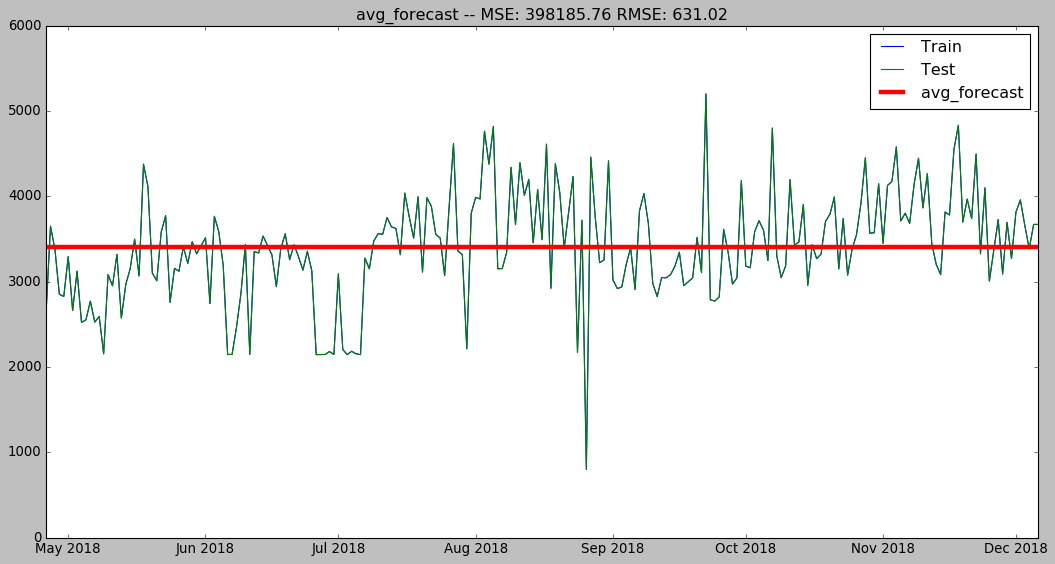

In [92]:
plot_and_eval(yhat.avg_forecast)

### Moving Average

In [95]:
periods = 30
yhat['moving_avg_forecast_30'] = train.rolling(30).mean().iloc[-1]

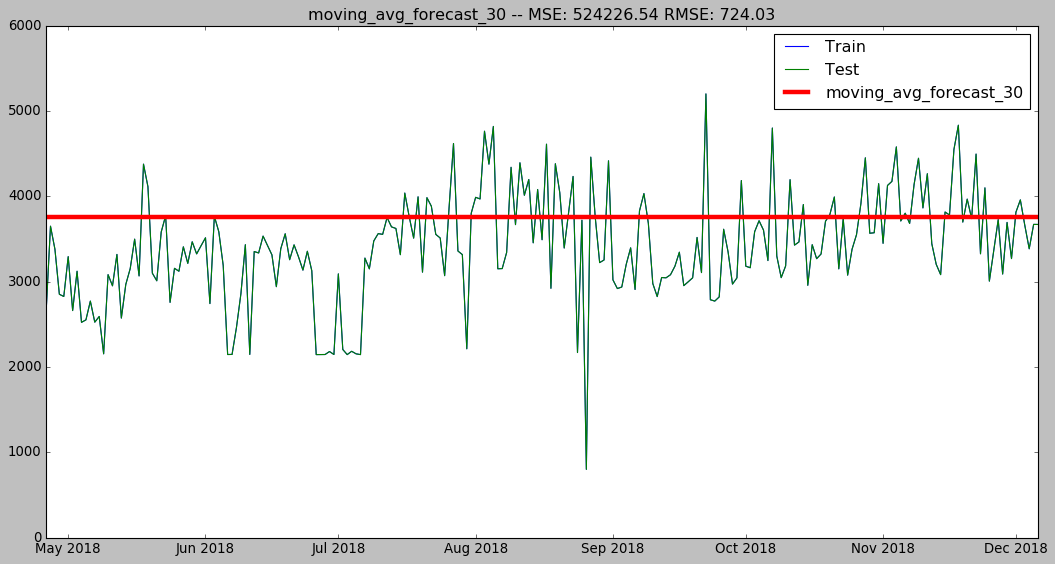

In [96]:
plot_and_eval(yhat.moving_avg_forecast_30)

### Holts Linear Trend Model

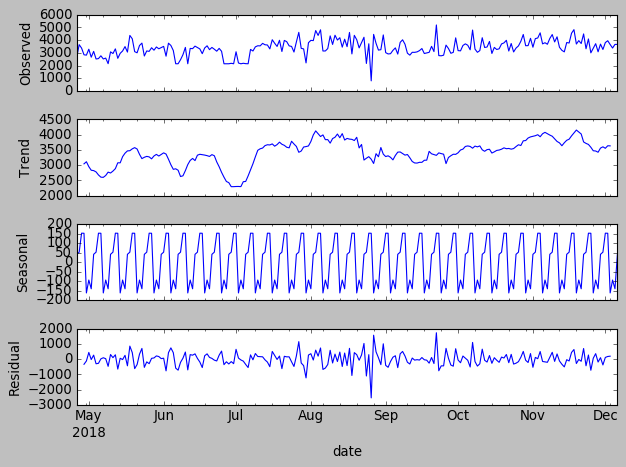

In [109]:
train = df[:'2018'].calories_burned.resample('D').agg(aggregation)
test = df['2018':].calories_burned.resample('D').agg(aggregation)

sm.tsa.seasonal_decompose(train).plot()
result = sm.tsa.stattools.adfuller(train)

plt.show()

#### Holt's Linear trend

In [ ]:
sm.tsa.seasonal_decompose(train).plot()
result = sm.tsa.stattools.adfuller(train)
plt.show()